# Pytorch implementation of Transfer learning on AlexNet

In [0]:
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import os

import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Normalizing the data according to ImageNet statistics

All models available in TorchVision are for ImageNet dataset [224x224x3].
But here we are using AlexNet for a  different dataset with input size [256x256x3]. Therefore resizing is required

In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    'test': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
}

In [27]:
!unzip "/content/drive/My Drive/Scenery_dataset.zip"

Archive:  /content/drive/My Drive/Scenery_dataset.zip
   creating: Scenery_dataset/
  inflating: Scenery_dataset/.DS_Store  
replace __MACOSX/Scenery_dataset/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/Scenery_dataset/._.DS_Store  
   creating: Scenery_dataset/test/
  inflating: Scenery_dataset/test/.DS_Store  
replace __MACOSX/Scenery_dataset/test/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/Scenery_dataset/test/._.DS_Store  
   creating: Scenery_dataset/test/7/
  inflating: Scenery_dataset/test/7/88.jpg  
  inflating: Scenery_dataset/test/7/599.jpg  
  inflating: Scenery_dataset/test/7/566.jpg  
  inflating: Scenery_dataset/test/7/764.jpg  
  inflating: Scenery_dataset/test/7/375.jpg  
  inflating: Scenery_dataset/test/7/177.jpg  
  inflating: Scenery_dataset/test/7/76.jpg  
  inflating: Scenery_dataset/test/7/377.jpg  
  inflating: Scenery_dataset/test/7/772.jpg  
  inflating: Scenery_dataset/test/7/766.jpg  
  inflating: 

## Dataset format:
**Scenery_dataset**
>train
>>1\
>>2\
>>3\
>>4\
>>5\
>>6\
>>7\
>>8

>test
>>1\
>>2\
>>3\
>>4\
>>5\
>>6\
>>7\
>>8




In [0]:
data_dir = '/content/Scenery_dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [7]:
print(dataloaders) # Dataloaders have been created for Train and Test dataset

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f63950c42b0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f63950c4470>}


In [8]:
print(class_names) # Class names

['1', '2', '3', '4', '5', '6', '7', '8']


# Loading the Pretrained AlexNet model

In [0]:
model = models.alexnet(pretrained=True)    #Loading the pretrained model

In [10]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [11]:
model.classifier # We need to make changes to the last classifier layer, to output 8 classes

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [12]:
print(model.parameters)

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=92

# Freezing the parameters

In [0]:
for param in model.parameters():
  param.requires_grad = False

In [0]:
model.classifier[-1] = nn.Sequential(
                       nn.Linear(in_features=4096, out_features=8),
                       nn.LogSoftmax(dim=1)
                        )

In [15]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=8, bias=True)
    (1): LogSoftmax()
  )
)

In [0]:
criterion = nn.NLLLoss() # "Negative log likelihood "loss func that takes in what the model predicts and the correct label

# Optimizer

In [0]:
from torch.optim import Adam

model = model.to(device)
optimizer = Adam(model.parameters())

# Training

In [18]:
num_epochs = 10
batch_loss = 0
cum_epoch_loss = 0
trainloader = dataloaders['train']
for e in range(num_epochs):
  batch_loss = 0
  for batch, (images, labels) in enumerate(dataloaders['train'],1):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    logps = model(images)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()
    
    batch_loss += loss.item()
    print(f'Epoch({e}/{num_epochs} : Batch number({batch}/{len(trainloader)})  Batch loss : {loss.item()}')
  cum_epoch_loss = cum_epoch_loss +  (batch_loss/len(trainloader))
  print(f'Training loss : {batch_loss/len(trainloader)}')  
print(f'Overall Training loss: {cum_epoch_loss/num_epochs}')

Epoch(0/10 : Batch number(1/30)  Batch loss : 2.0503437519073486
Epoch(0/10 : Batch number(2/30)  Batch loss : 1.7098455429077148
Epoch(0/10 : Batch number(3/30)  Batch loss : 1.242175817489624
Epoch(0/10 : Batch number(4/30)  Batch loss : 1.2048629522323608
Epoch(0/10 : Batch number(5/30)  Batch loss : 0.9523953795433044
Epoch(0/10 : Batch number(6/30)  Batch loss : 0.8866384625434875
Epoch(0/10 : Batch number(7/30)  Batch loss : 0.8396710157394409
Epoch(0/10 : Batch number(8/30)  Batch loss : 0.7118005156517029
Epoch(0/10 : Batch number(9/30)  Batch loss : 0.6939565539360046
Epoch(0/10 : Batch number(10/30)  Batch loss : 0.5343207120895386
Epoch(0/10 : Batch number(11/30)  Batch loss : 0.5844676494598389
Epoch(0/10 : Batch number(12/30)  Batch loss : 0.4115807116031647
Epoch(0/10 : Batch number(13/30)  Batch loss : 0.6334996819496155
Epoch(0/10 : Batch number(14/30)  Batch loss : 0.39265531301498413
Epoch(0/10 : Batch number(15/30)  Batch loss : 0.45531371235847473
Epoch(0/10 : Batch

# Evaluating the model and viewing images

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [20]:
dataset_classes = ['1', '2', '3', '4',
           '5', '6', '7', '8']


model.to('cpu')

model.eval()
testloader = dataloaders['test']
with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)
  
  output = torch.exp(logps)
  print(output)


# Output of the last eight layers for 1 batch of test images in terms of probability of the image
# belonging to that class

tensor([[4.3787e-06, 2.3929e-06, 1.5985e-03, 1.0328e-01, 9.5298e-07, 7.3669e-07,
         8.2112e-03, 8.8690e-01],
        [3.3184e-03, 1.1004e-03, 7.8608e-02, 1.5323e-04, 3.1732e-02, 8.8448e-01,
         5.7034e-04, 4.1319e-05],
        [1.1328e-07, 5.7170e-08, 7.2394e-06, 2.5820e-05, 4.2569e-07, 2.5025e-07,
         9.9997e-01, 3.4360e-07],
        [6.2128e-03, 1.4621e-01, 9.9109e-04, 3.7147e-05, 8.2212e-01, 2.3312e-02,
         9.8151e-04, 1.3578e-04],
        [2.1288e-06, 1.7619e-05, 1.5437e-07, 1.9324e-07, 9.9996e-01, 1.2666e-05,
         4.0102e-06, 1.4266e-06],
        [6.2589e-01, 1.6914e-03, 2.5169e-02, 9.4461e-05, 3.2540e-03, 3.4081e-01,
         3.2257e-04, 2.7672e-03],
        [2.2715e-04, 6.4438e-01, 2.0298e-03, 6.6796e-04, 2.3451e-06, 3.5266e-01,
         2.6128e-05, 7.8847e-06],
        [1.1180e-03, 9.9418e-01, 6.9736e-05, 4.7979e-05, 4.3036e-04, 2.8070e-03,
         2.7767e-04, 1.0668e-03],
        [9.8996e-01, 3.6169e-06, 1.1564e-03, 4.1903e-05, 6.7200e-05, 8.7373e-03,

# Heat map

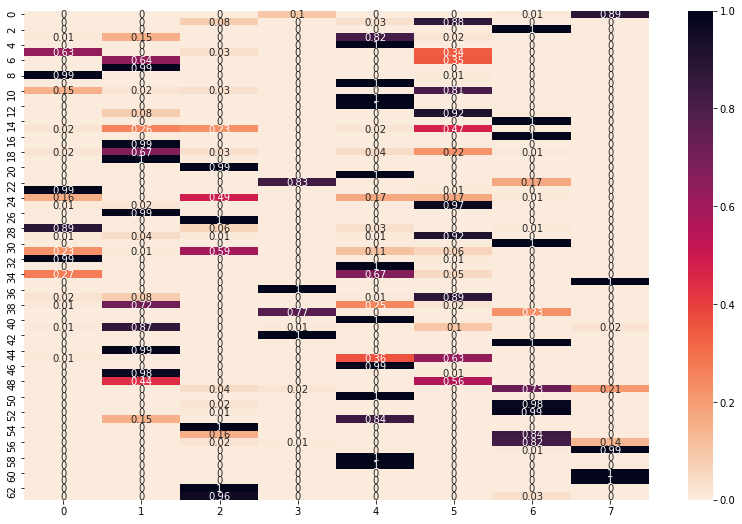

In [20]:
import seaborn as sn
import pandas as pd 
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(output, range(64), range(8))
plt.figure(figsize=(14,9))
cmap = sn.cm.rocket_r
sn.heatmap(df_cm.round(2), annot=True, fmt='g', cmap=cmap)

In [21]:
dataset_classes = ['1', '2', '3', '4',
           '5', '6', '7', '8']

testloader = dataloaders['test']
model.to('cpu')

model.eval()  # Setting the model in evaluation mode

with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)
  
  output = torch.exp(logps)
  
  pred = torch.argmax(output,1)
    
model.train()  # Setting the model back in training mode

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [22]:
pred, labels

(tensor([1, 7, 0, 5, 2, 0, 1, 6, 1, 4, 1, 0, 2, 7, 3, 4, 5, 3, 3, 2, 5, 3, 2, 1,
         4, 4, 7, 6, 5, 7, 3, 4, 6, 6, 4, 0, 0, 6, 5, 1, 0, 1, 7, 2, 5, 7, 7, 7,
         7, 4, 4, 2, 7, 3, 5, 3, 3, 7, 7, 0, 2, 6, 7, 2]),
 tensor([1, 7, 0, 5, 2, 0, 1, 6, 1, 4, 1, 0, 2, 7, 3, 4, 1, 6, 3, 2, 5, 3, 2, 1,
         4, 4, 7, 6, 5, 7, 3, 4, 6, 6, 4, 0, 0, 6, 2, 1, 0, 1, 7, 2, 5, 7, 7, 7,
         7, 4, 4, 2, 7, 3, 5, 3, 3, 7, 7, 0, 2, 3, 7, 2]))

# Confusion matrix

In [23]:
pred == labels

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True])

coast


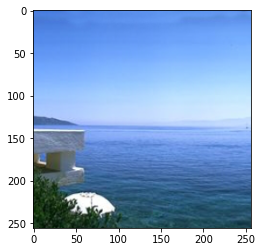

In [24]:
test_image_id=2

def denormalize(tensor):
  tensor = tensor*std+ mean
  return tensor

def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img,0,1)
  plt.imshow(img)
  
def get_dataset_class(id):
    dataset_classes = ['coast', 'mountain', 'forest', 'open country', 'street', 'inside city', 'tall buildings',
                       'highways']
    #dataset_classes = ['1', '2', '3', '4','5', '6', '7', '8']
    return dataset_classes[id]

show_img(images[test_image_id])
print(get_dataset_class(pred[test_image_id]))

In [25]:
model.eval()
testloader = dataloaders['test']
with torch.no_grad():
    num_correct = 0
    total = 0


    for batch, (images, labels) in enumerate(testloader,1):
        
        logps = model(images)
        output = torch.exp(logps)
        
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()
        print(f'Batch ({batch}/{len(testloader)})')

    print(f'Accuracy of the model on {total} test images: {num_correct * 100 / total}% ')

Batch (1/13)
Batch (2/13)
Batch (3/13)
Batch (4/13)
Batch (5/13)
Batch (6/13)
Batch (7/13)
Batch (8/13)
Batch (9/13)
Batch (10/13)
Batch (11/13)
Batch (12/13)
Batch (13/13)
Accuracy of the model on 800 test images: 90.25% 
